In [1]:
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path

# TP2

In [2]:
filenames = glob('DataSujetos/*.csv')
df = pd.read_csv(filenames[0], header=-1)
n = df.shape[0]
df -= np.diag(np.ones(n))

print("Nro de archivos = " + str(len(filenames)))
subjects = set()
sleepStages = set()
for filename in filenames:
        subjects.add(filename[filename.index('_') + 1:-4])
        sleepStages.add(filename[filename.index('/') + 1: filename.index('_')])
print("Nro de sujetos = " + str(len(subjects)))
print("Nro de estadios = " + str(len(sleepStages)))
       

Nro de archivos = 72
Nro de sujetos = 18
Nro de estadios = 4


In [3]:
#Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
def subjectmatrix2graphslist(filename, densities):
    correlation_matrix = pd.read_csv(filename, header=-1)
    n = correlation_matrix.shape[0]
    n2m1 = (n*n-1)
    correlation_matrix -= np.diag(np.ones(n))
    sorted_correlations = sorted(correlation_matrix.values.flatten(),reverse=True)
    
    Gs = []
    for d in densities:
        idx = int(d*n2m1)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
    return Gs

def graphslistBySleepStage(sleepStage, densities):
    filenames = glob('DataSujetos/%s_*.csv' % sleepStage)
    graphs = {}
    for filename in filenames:
        Gs = subjectmatrix2graphslist(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs
    return graphs    
    
    
densities = np.linspace(0,1,50)

graphsBySleepStage = {}

#se arma una mapa por estadio de sueño con los grafos de cada individuo
for sleepStage in sleepStages: 
    graphsBySleepStage[sleepStage] = graphslistBySleepStage(sleepStage, densities)



## Tarea 1: Visualización



In [15]:
#Funciones para calcular y dibujar los graficos por estadio de sueño
#calcular medida
def calculateMeasure(graphs, calculateMeasureByGraph):
    value = []
    for name, Gs in graphs.items():
        value_ =  [calculateMeasureByGraph(G) for G in Gs]
        value.append(value_)
    value = np.vstack(value)
    return value


#Dibujar graficos por estadio
def plotGraphMeasureBySleepStage(xlabel,ylabel, graphsBySleepStage, densities, calculateMeasureByGraph):
    plt.figure(figsize=(20,10))

    for i, sleepStage in enumerate(sleepStages):
        measure = calculateMeasure(graphsBySleepStage[sleepStage], calculateMeasureByGraph)
        plt.subplot(2,2,i+1)
        plt.plot(densities, measure.T);
        if (i != 0 and i != 1):
            plt.xlabel(xlabel)
        plt.ylabel(ylabel);
        plt.title(sleepStage)

### Medida de Centralidad 

#### Grado

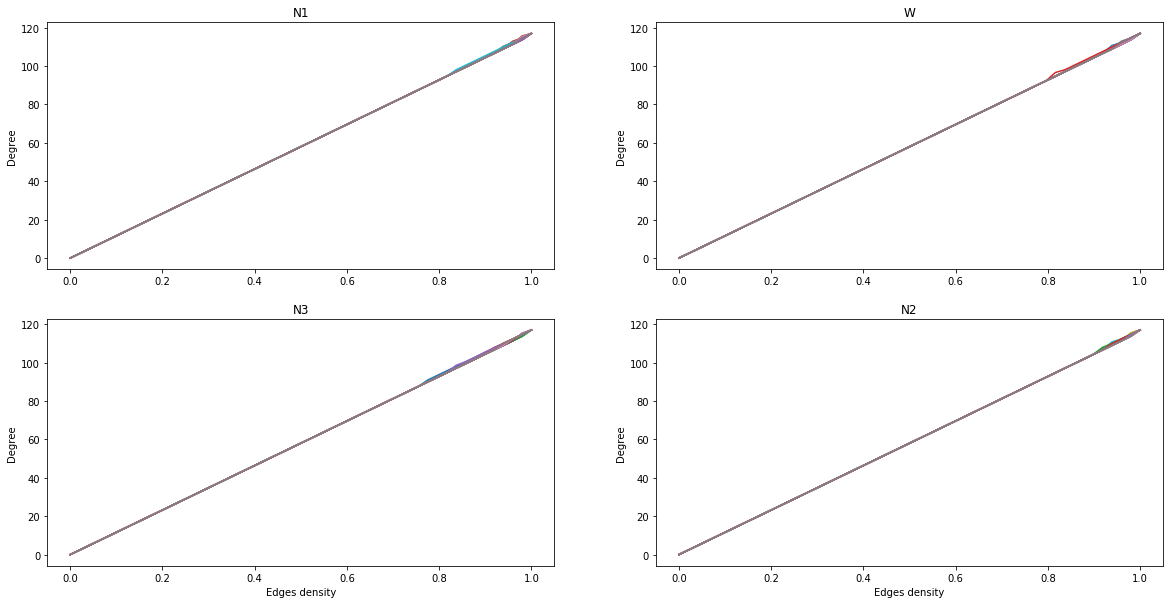

In [16]:
def calculateDegree(graph):
    return np.mean([v for n,v in graph.degree])

plotGraphMeasureBySleepStage('Edges density', 'Degree', graphsBySleepStage, densities, calculateDegree)    


#### Camino mínimo

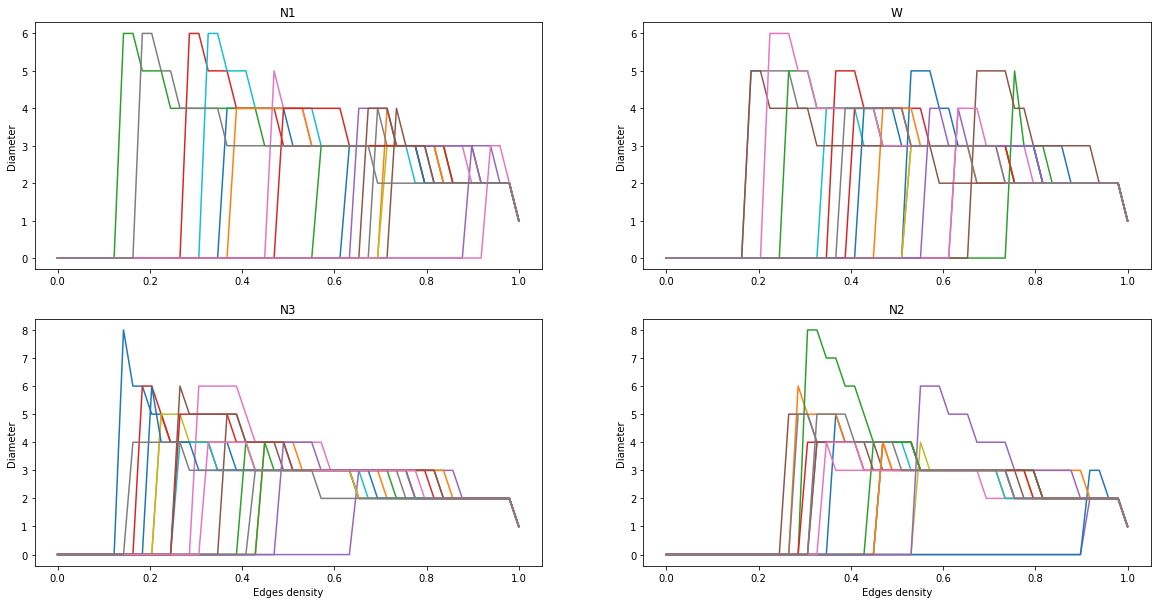

In [17]:
def calculateDiameterIfConnected(G):
     if (nx.is_connected(G)):
            return nx.diameter(G)
     return 0   

plotGraphMeasureBySleepStage('Edges density', 'Diameter', graphsBySleepStage, densities, calculateDiameterIfConnected)    



#### Closeness Centrality

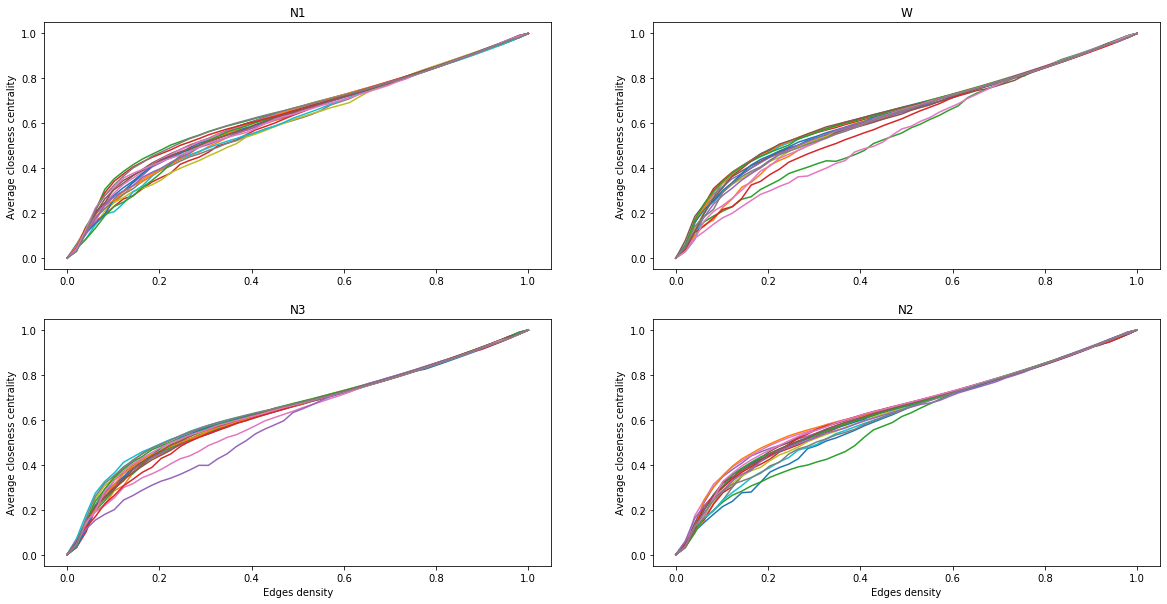

In [19]:
def calculateAvgClosenessCentrality(G):
    return np.mean([v for n, v in dict(nx.closeness_centrality(G)).items()]) 

plotGraphMeasureBySleepStage('Edges density', 'Average closeness centrality', graphsBySleepStage, densities, calculateAvgClosenessCentrality)    


#### Coeficiente de clustering

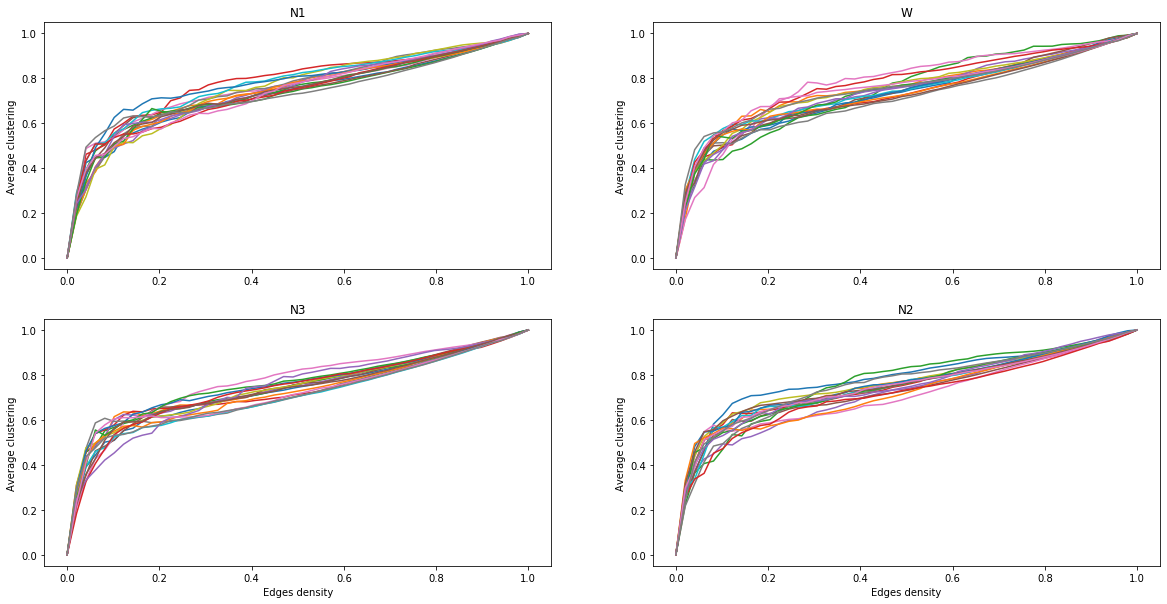

In [18]:
plotGraphMeasureBySleepStage('Edges density', 'Average clustering', graphsBySleepStage, densities, nx.average_clustering)    
    